# Competition research

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import pylab
%matplotlib inline

## Background

### Goal

* Detect visual signals of pneumonia.
* Need to automatically locate lung opacities on chest radiographs.

### Evaluation metric

> Mean average precision at different intersection over union thresholds. The metric sweeps over a
> range of $IoU$ thresholds (namely 0.4 to 0.75 in increments of 0.05), at each point calculating
> an average precision value. 

To understand this, we need to know these things:

* What is Intersection over Union?
* What is precision?
* What is the average precision value?

#### What is intersection over union?

$IoU$ is defined as:

$$IoU(A,B) = \frac{A \cap B}{A \cup B}$$

This mearsures the extent of overlap between the ground-truth bounding box and the predicted bounding box as a proportion of the total area covered by the two bounding boxes.

<img src='.\assets_competition_research\intersection_over_union.png'>

#### An example

Here, the ground-truth bounding box is created manually by a human. The predicted bounding box is the algorithm's prediction of where the object is.

<img src='.\assets_competition_research\intersection_over_union_example.png'>

#### What is precision?

Precision is the percentage of your positive predictions that are correct. It is defined as:

$$Precision = \frac{TP}{TP + FP}$$

Related to precision is recall, which is a measure of how well your model classifies positive values given all positive values:

$$Recall = \frac{TP}{TP + FN}$$

#### What is precision in the context of this competition?

At each threshold value $t$, a precision value is calculated based on the number of true positives, false positives and false negatives:

$$\frac{TP(t)}{TP(t) + FP(t) + FN(t)}$$

*When is a true positive counted in the above precision value?*

$TP(t) = \text{single predicted bounding box matches ground truth bounding box with an IoU above threshold, t}$

*When is a false positive counted in the above precision value?*

$FP(t) = \text{single predicted bounding box has no associated ground truth bounding box}$

*When is a false negative counted in the above precision value?*

$FN(t) = \text{no predicted bounding box when there is a ground truth bounding box}$


#### What happens if there are no ground truth objects for an image, but we predict that there is a bounding box?

The image will receive a score of zero.

#### What is mean precision?

##### Per image

Mean precision for a single image is calculated as the mean of the precision values at each $IoU$ threshold:

$$\frac{1}{|thresholds|}\sum_t\frac{TP(t)}{TP(t) + FP(t) + FN(t)}$$

###### Across all images 

The final score is the mean of the per image mean precision values. 

## Submission file

Space delimited set of bounding boxes, in the format:

`<`image_name`>`, `<`confidence`>`, `<`x`>`, `<`y`>`, `<`width`>`, `<`height`>`

where:

* confidence = some confidence level of the bounding box. Apparently it's used to break ties to detemine the order in which bounding boxes are evaluated by the evaluation metric. We can hardcode with $1.0$ for all to make our lives easier because it is rarely used. 
* x = x coordinate of the upper left hand corner
* y = y coordinate of the upper left hand corner
* width = width in pixels from the coordinate (x, y)
* height = height in pixels from the coordinate (x, y)

Each row should contain all bounding boxes for a given image. E.g:

> 00322d4d-1c29-4943-afc9-b6754be640eb,0.8 10 10 50 50 0.75 100 100 5 5

contains 2 bounding boxes - one with a confidence of 0.8, and another with a confidence of 0.75.

### Competition data

* DICOM images
* stage_1_train_labels.csv
* stage_1_detailed_class_info.csv

#### DICOM images

DICOM is a format used to store medical images. They contain metadata (e.g. patient information, date taken) and pixel arrays.


#### stage_1_train_labels.csv 

This file contains the ground-truth bounding boxes.

#### stage_1_detailed_class_info.csv

Contains further detail on patient images, split into three categories:

* Normal
* Lung Opacity
* No Lung Opacity / Not Normal

#### DICOM images

##### pydicom - working with DICOM files

We can use the pydicom package to read DICOM metadata and pixel arrays. We can use matplotlib to render the images themselves.

In [19]:
import pydicom

###### A pneumonia example

To read in the penumonia DICOM file, we can use read_file().

In [20]:
dcm_pneumonia = pydicom.read_file('assets_competition_research/pneumonia.dcm')

Let's take a look at the metadata.


In [21]:
print(dcm_pneumonia, 2)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [22]:
dir(dcm_pneumonia)

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setat

Here we extract the pixel arrays by referring to the pixel_array property of the object.

In [23]:
pneumonia_image = dcm_pneumonia.pixel_array
print(pneumonia_image)

[[0 1 2 ..., 2 2 2]
 [0 1 2 ..., 2 2 2]
 [0 1 2 ..., 3 3 3]
 ..., 
 [1 3 4 ..., 7 7 7]
 [0 2 3 ..., 5 5 5]
 [0 0 1 ..., 0 0 0]]


We can get the dimensions of the image by using the shape method.

In [24]:
print(pneumonia_image.shape)

(1024, 1024)


To plot the image, we use matplotlib.pyplot.imshow().

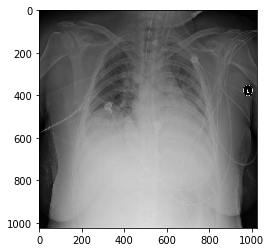

In [25]:
plot.imshow(pneumonia_image, cmap = pylab.cm.gist_gray)

###### A non-pneumonia example

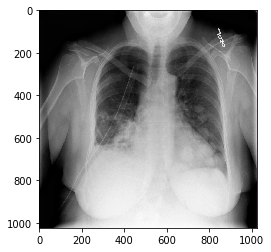

In [26]:
dcm_not_pneumonia = pydicom.read_file('assets_competition_research/not_pneumonia.dcm')
not_pneumonia_image = dcm_not_pneumonia.pixel_array
plot.imshow(not_pneumonia_image, cmap = pylab.cm.gist_gray)

###### Visualising bounding boxes

We will read the labelled training data csv into a pandas dataframe.

In [27]:
train_labels = pd.read_csv('../input/stage_1_train_labels.csv')

In [28]:
print(train_labels.columns)

Index(['patientId', 'x', 'y', 'width', 'height', 'Target'], dtype='object')


Let's use the parse_data() from the starter kernel to parse the csv file of labels into a nested dictionary.

In [29]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '../input/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [30]:
train_labels_dict = parse_data(train_labels)

Here, we find a patient who has pneumonia. Note the two bounding boxes.

In [31]:
print(train_labels_dict['00436515-870c-4b36-a041-de91049b9ab4'])

{'dicom': '../input/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm', 'label': 1, 'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]}


To draw the bounding boxes for this patient, we will use the functions provided in the starter kernel.

In [32]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

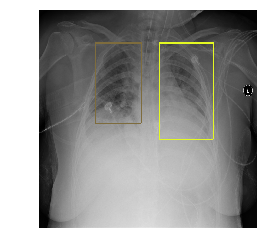

In [33]:
draw(train_labels_dict['00436515-870c-4b36-a041-de91049b9ab4'])

##### stage_1_detailed_class_info.csv

This file contains further information on the images. 3 classes are provided:

* Normal
* Lung Opacity
* No Lung Opacity / Not Normal

The third class (No Lung Opacity / Not Normal) indicates that pneumonia wasn't present, but some image abnormality was detected. These abnormalities may mimic the appearance of pneumonia. This information can be used to help improve the accuracy of our algorithms.

Let's take a look at an example of this third class.

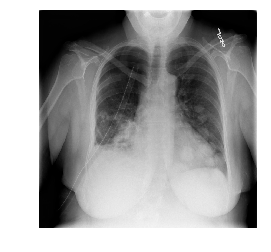

In [34]:
draw(train_labels_dict['0004cfab-14fd-4e49-80ba-63a80b6bddd6'])

## Conclusion

Let's do it!